# Анализ данных ИБП (предиктивное обслуживание)

Ноутбук для анализа синтетических данных по источникам бесперебойного питания: первичный осмотр, визуализация, временные ряды, корреляции, feature engineering и модель предсказания отказов.

## 1. Загрузка и первичный осмотр

### 1.1 Загрузка CSV и первые строки

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Загрузка данных (путь относительно папки notebooks)
data_path = Path("../data/ups_synthetic_2024_2025.csv")
df = pd.read_csv(data_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])

print("Первые 10 строк:")
df.head(10)

Первые 10 строк:


,timestamp,device_id,temperature,voltage_in,voltage_out,load_percent,battery_runtime_minutes,battery_cycles,battery_age_months,target
0,2024-01-01 00:00:00,IBP-01,21.88,240.00,225.00,21.67,31.74,0.59,0.46,0
1,2024-01-01 01:00:00,IBP-01,24.87,238.96,223.66,20.21,27.84,3.49,0.94,0
2,2024-01-01 02:00:00,IBP-01,24.99,240.00,225.00,20.06,28.71,0.00,0.66,0
3,2024-01-01 03:00:00,IBP-01,23.52,239.16,225.00,20.00,31.58,4.79,0.00,0
4,2024-01-01 04:00:00,IBP-01,23.64,239.99,225.00,24.79,30.55,69.39,0.00,0
5,2024-01-01 05:00:00,IBP-01,23.09,239.85,223.58,23.81,31.79,1.48,0.00,0
6,2024-01-01 06:00:00,IBP-01,21.40,238.41,224.97,20.78,29.11,10.67,1.05,0
7,2024-01-01 07:00:00,IBP-01,23.94,240.00,225.00,21.06,29.29,17.22,0.06,0
8,2024-01-01 08:00:00,IBP-01,23.12,239.99,224.69,20.00,30.67,1.37,0.21,0
9,2024-01-01 09:00:00,IBP-01,24.43,239.66,225.00,20.47,28.08,27.23,0.52,0


### 1.2 Информация о данных (типы, пропуски)

In [25]:
df.info()
print("\nПропуски по столбцам:")
print(df.isnull().sum())
print(f"\nВсего записей: {len(df)}, устройств: {df['device_id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350880 entries, 0 to 350879
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   timestamp                350880 non-null  datetime64[ns]
 1   device_id                350880 non-null  object        
 2   temperature              350880 non-null  float64       
 3   voltage_in               350880 non-null  float64       
 4   voltage_out              350880 non-null  float64       
 5   load_percent             350880 non-null  float64       
 6   battery_runtime_minutes  350880 non-null  float64       
 7   battery_cycles           350880 non-null  float64       
 8   battery_age_months       350880 non-null  float64       
 9   target                   350880 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 26.8+ MB

Пропуски по столбцам:
timestamp                  0
device_id  

### 1.3 Базовая статистика

In [26]:
df.describe()

,timestamp,temperature,voltage_in,voltage_out,load_percent,battery_runtime_minutes,battery_cycles,battery_age_months,target
count,350880,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000
mean,2024-12-31 11:30:00.000000256,29.074853,239.178796,224.592552,40.639880,29.927736,150.389936,14.872427,0.002394
min,2024-01-01 00:00:00,20.000000,228.570000,220.110000,20.000000,5.550000,0.000000,0.000000,0.000000
25%,2024-07-01 17:45:00,25.630000,238.620000,224.320000,32.150000,28.620000,75.110000,7.210000,0.000000
50%,2024-12-31 11:30:00,27.780000,239.950000,224.970000,36.950000,29.990000,150.170000,10.530000,0.000000
75%,2025-07-02 05:15:00,33.230000,240.000000,225.000000,54.460000,31.340000,225.040000,27.050000,0.000000
max,2025-12-31 23:00:00,47.480000,240.000000,225.000000,79.580000,39.220000,370.020000,36.000000,1.000000
std,NaN,4.929599,1.195550,0.590137,14.606818,2.240546,88.271274,10.867141,0.048870


## 2. Визуализация распределений

### 2.1 Гистограммы всех параметров

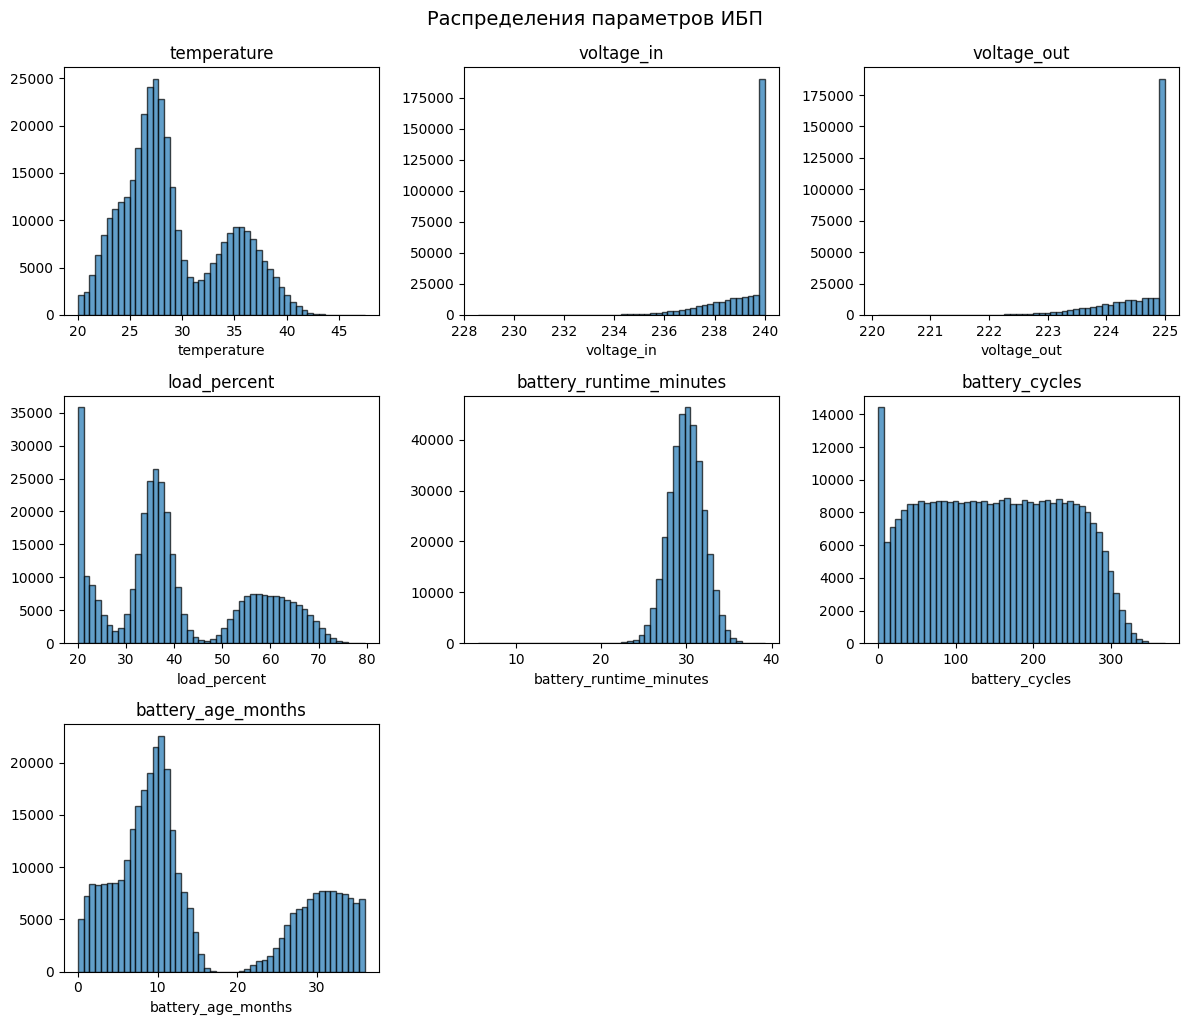

In [27]:
# Числовые колонки без target и идентификаторов
numeric_cols = ["temperature", "voltage_in", "voltage_out", "load_percent",
                "battery_runtime_minutes", "battery_cycles", "battery_age_months"]

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.suptitle("Распределения параметров ИБП", y=1.02, fontsize=14)
plt.show()
# Инсайт: температура и нагрузка имеют широкий разброс; напряжение входа/выхода — более узкие диапазоны.

### 2.2 Сравнение распределений для target=0 и target=1

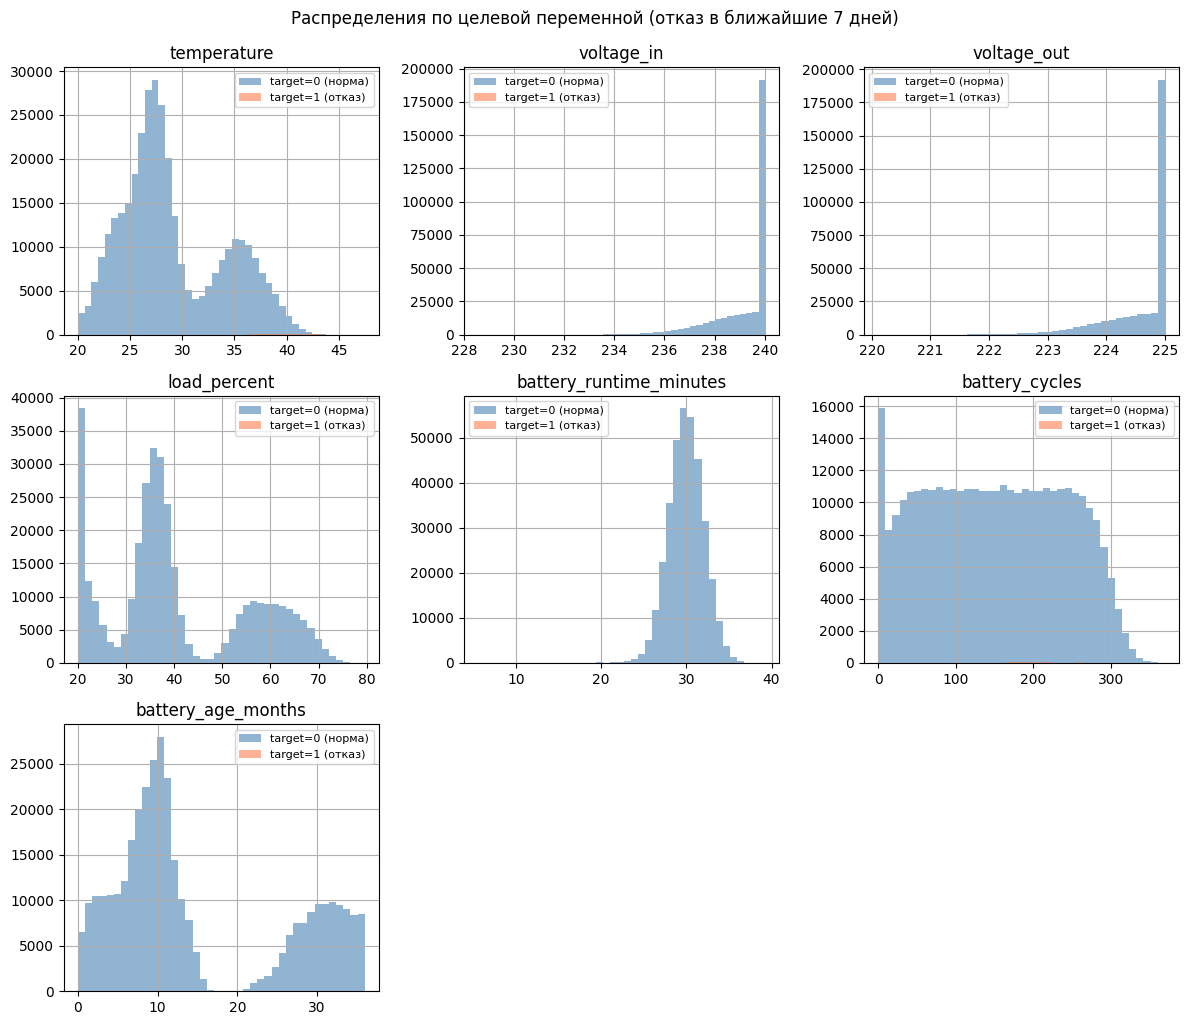

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df[df["target"] == 0][col].hist(ax=axes[i], bins=40, alpha=0.6, label="target=0 (норма)", color="steelblue")
    df[df["target"] == 1][col].hist(ax=axes[i], bins=40, alpha=0.6, label="target=1 (отказ)", color="coral")
    axes[i].set_title(col)
    axes[i].legend(fontsize=8)
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.suptitle("Распределения по целевой переменной (отказ в ближайшие 7 дней)", y=1.02, fontsize=12)
plt.show()
# Инсайт: при target=1 чаще наблюдаются более высокая температура, выше нагрузка и ниже battery_runtime — признаки деградации.

### 2.3 Box plots по device_id

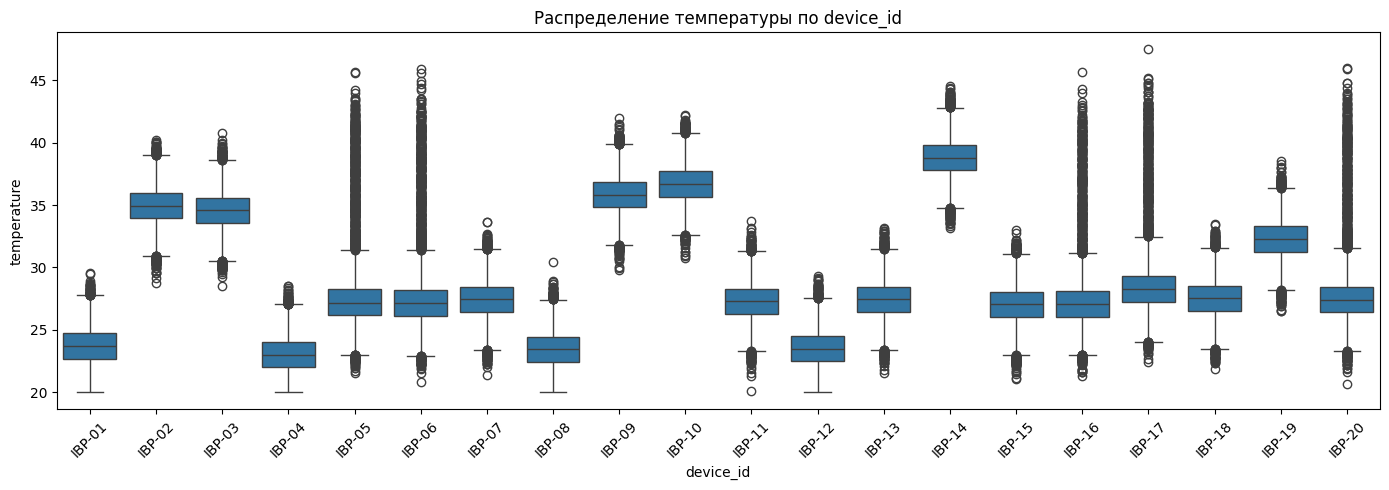

In [29]:
# Box plot температуры по устройствам (пример ключевого параметра)
plt.figure(figsize=(14, 5))
sns.boxplot(data=df, x="device_id", y="temperature", order=sorted(df["device_id"].unique()))
plt.xticks(rotation=45)
plt.title("Распределение температуры по device_id")
plt.tight_layout()
plt.show()
# Инсайт: разброс температуры по устройствам помогает выявить «горячие» ИБП и потенциальные кандидаты на отказ.

## 3. Анализ временных рядов

Выбираем два ИБП: один с отказом (target=1 в части записей), один без отказа. Строим графики параметров за 60 дней до отказа (или до конца данных для исправного).

In [42]:
# Выбор устройств: одно с отказом, одно без
failing_devices = df[df["target"] == 1]["device_id"].unique()
all_devices = df["device_id"].unique()
non_failing = [d for d in all_devices if d not in failing_devices]

device_fail = failing_devices[0]   # ИБП с отказом
device_ok = non_failing[0]         # ИБП без отказа

# Момент "отказа" для ломающегося: последний час с target=1 (граница предотказного окна)
fail_ts = df[(df["device_id"] == device_fail) & (df["target"] == 1)]["timestamp"].max()
window_start = fail_ts - pd.Timedelta(days=60)

df_fail = df[(df["device_id"] == device_fail) & (df["timestamp"] >= window_start) & (df["timestamp"] <= fail_ts)].copy()
df_ok = df[df["device_id"] == device_ok].copy()
# Для исправного берём последние 60 дней
end_ok = df_ok["timestamp"].max()
df_ok = df_ok[df_ok["timestamp"] >= end_ok - pd.Timedelta(days=60)]

print(f"ИБП с отказом: {device_fail}, момент отказа (вертикальная линия): {fail_ts}")
print(f"ИБП без отказа: {device_ok}, период: последние 60 дней")

ИБП с отказом: IBP-05, момент отказа (вертикальная линия): 2025-03-02 07:00:00
ИБП без отказа: IBP-01, период: последние 60 дней


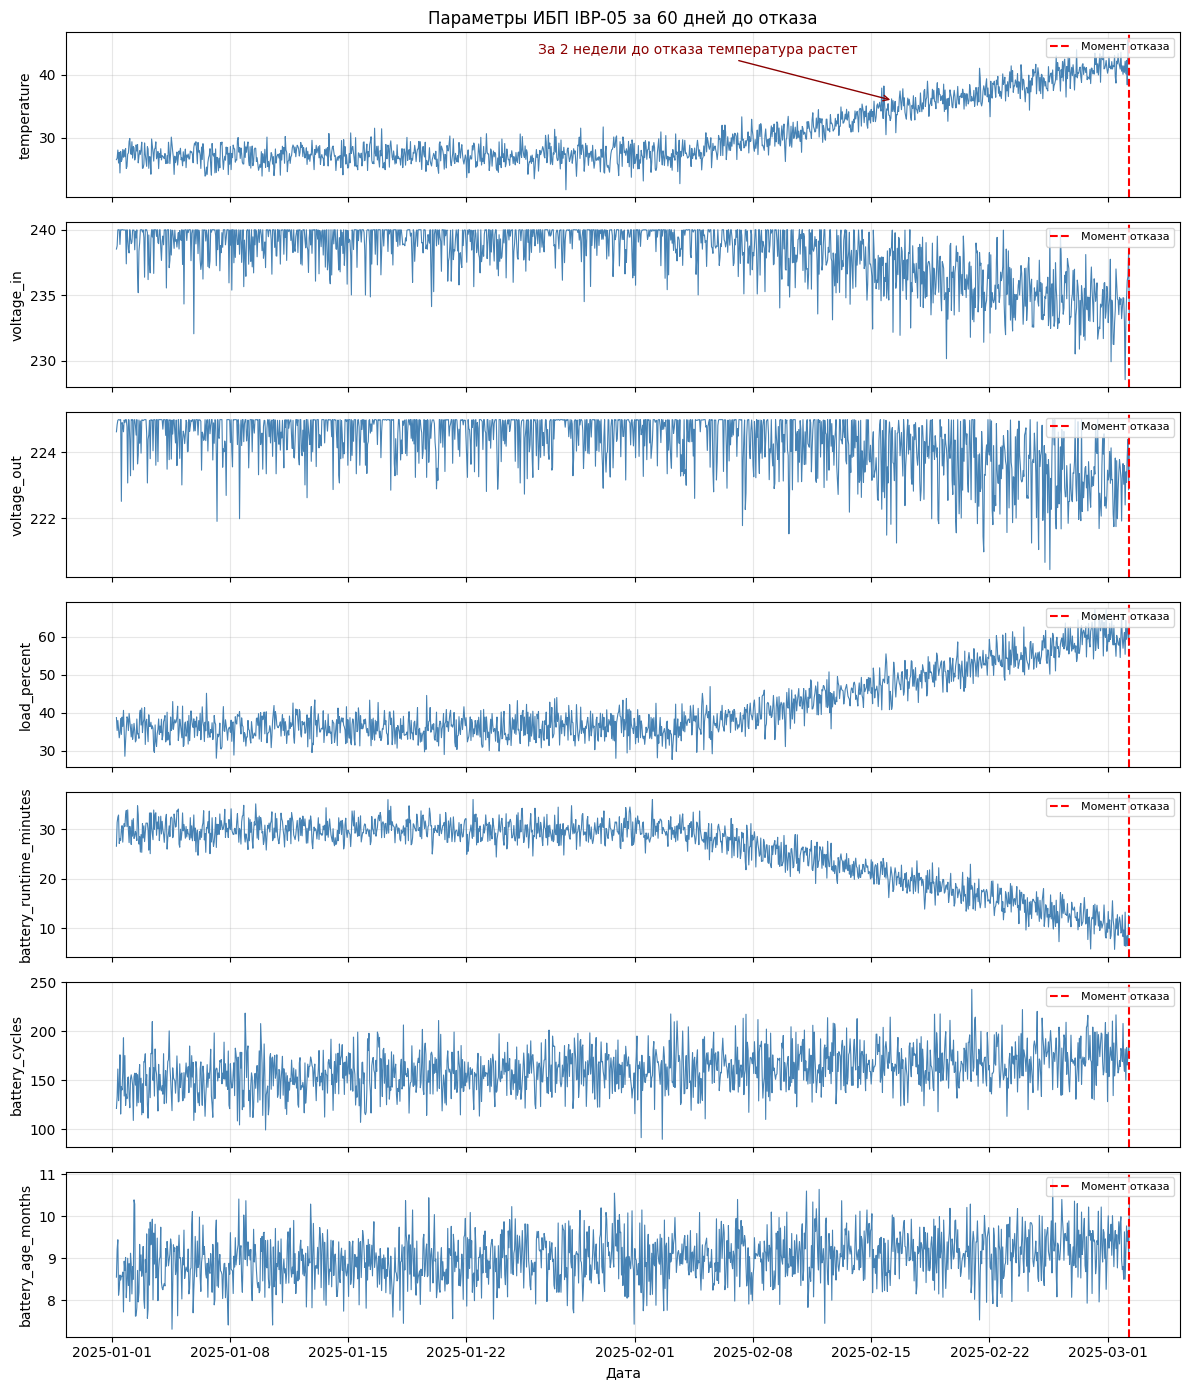

In [43]:
# Графики всех параметров за 60 дней до отказа (ломающийся ИБП)
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 14), sharex=True)
for i, col in enumerate(numeric_cols):
    axes[i].plot(df_fail["timestamp"], df_fail[col], color="steelblue", linewidth=0.8)
    axes[i].axvline(fail_ts, color="red", linestyle="--", label="Момент отказа")
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right", fontsize=8)
    axes[i].grid(True, alpha=0.3)
axes[0].set_title(f"Параметры ИБП {device_fail} за 60 дней до отказа")
axes[-1].set_xlabel("Дата")
plt.tight_layout()
# Аннотация: за 2 недели до отказа температура растёт
ax_temp = axes[numeric_cols.index("temperature")]
ts_14d = fail_ts - pd.Timedelta(days=14)
subset = df_fail[df_fail["timestamp"] <= ts_14d]
y_14d = subset["temperature"].iloc[-1] if len(subset) > 0 else df_fail["temperature"].mean()
ax_temp.annotate(
    "За 2 недели до отказа температура растет",
    xy=(ts_14d, y_14d),
    fontsize=10, color="darkred",
    xytext=(fail_ts - pd.Timedelta(days=35), df_fail["temperature"].max() * 0.95),
    arrowprops=dict(arrowstyle="->", color="darkred"),
)
plt.show()

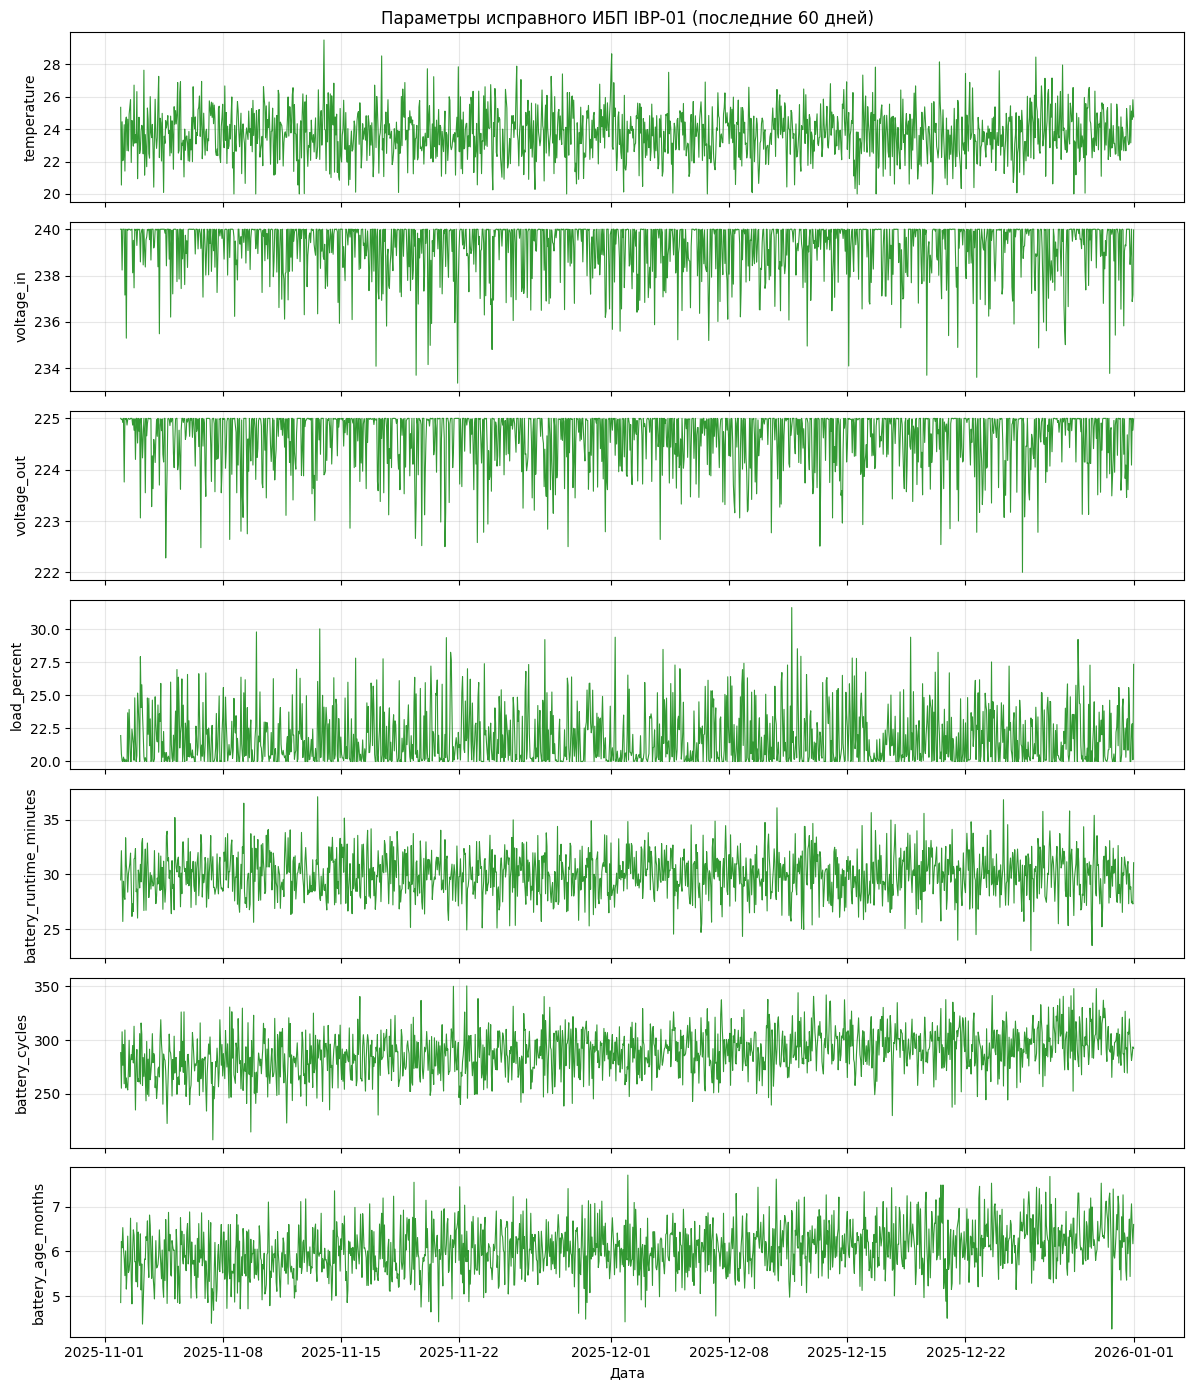

In [32]:
# Графики для исправного ИБП (последние 60 дней, без отказа)
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 14), sharex=True)
for i, col in enumerate(numeric_cols):
    axes[i].plot(df_ok["timestamp"], df_ok[col], color="green", linewidth=0.8, alpha=0.8)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
axes[0].set_title(f"Параметры исправного ИБП {device_ok} (последние 60 дней)")
axes[-1].set_xlabel("Дата")
plt.tight_layout()
plt.show()
# Инсайт: у исправного ИБП параметры остаются в стабильном диапазоне без выраженного тренда к отказу.

## 4. Корреляционный анализ

### 4.1 Матрица корреляций (тепловая карта)

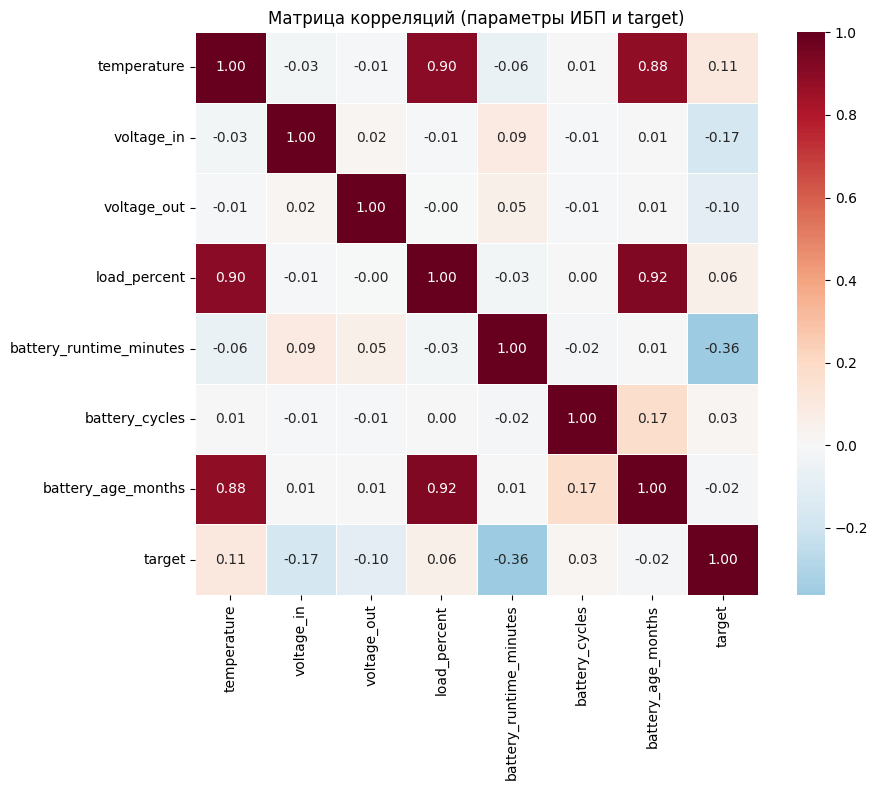

In [33]:
# Корреляция с target и между признаками
cols_for_corr = numeric_cols + ["target"]
corr = df[cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True, linewidths=0.5)
plt.title("Матрица корреляций (параметры ИБП и target)")
plt.tight_layout()
plt.show()

In [34]:
# Корреляции с target по убыванию
target_corr = corr["target"].drop("target").sort_values(key=abs, ascending=False)
print("Корреляция с target (по убыванию абсолютного значения):")
print(target_corr)
# Комментарий: сильнее всего с target коррелируют температура (положительно), нагрузка (положительно),
# время работы батареи (отрицательно) — при приближении отказа температура и нагрузка растут, runtime падает.

Корреляция с target (по убыванию абсолютного значения):
battery_runtime_minutes   -0.361615
voltage_in                -0.174496
temperature                0.108801
voltage_out               -0.101137
load_percent               0.055306
battery_cycles             0.025439
battery_age_months        -0.016972
Name: target, dtype: float64


## 5. Feature engineering

Создаём признаки: тренд температуры за 7 дней, СКО напряжения за 3 дня, изменение нагрузки за 7 дней, «здоровье» батареи (runtime/возраст).

In [36]:
# Сортируем по устройству и времени для скользящих окон
df_sorted = df.sort_values(["device_id", "timestamp"]).copy()

def rolling_features_by_device(g):
    w7 = 7 * 24   # 7 дней в часах
    w3 = 3 * 24   # 3 дня
    g = g.sort_values("timestamp")
    # Тренд температуры за 7 дней (линейный наклон: прирост за период)
    g["temp_trend_7d"] = g["temperature"].rolling(window=w7, min_periods=2).apply(
        lambda x: (x[-1] - x[0]) / (len(x) - 1) if len(x) > 1 else 0, raw=True
    )
    g["voltage_std_3d"] = g["voltage_out"].rolling(window=w3, min_periods=1).std().fillna(0)
    g["load_change_7d"] = g["load_percent"].rolling(window=w7, min_periods=2).apply(
        lambda x: x[-1] - x[0] if len(x) > 1 else 0, raw=True
    )
    # battery_health: runtime / (1 + age), чтобы не делить на 0
    g["battery_health"] = g["battery_runtime_minutes"] / (1 + g["battery_age_months"])
    return g

df_fe = df_sorted.groupby("device_id", group_keys=False).apply(rolling_features_by_device, include_groups=False)
# Восстанавливаем device_id (при include_groups=False он не попадает в группы)
df_fe["device_id"] = df_sorted.loc[df_fe.index, "device_id"].values
# Заполняем оставшиеся NaN в rolling-признаках нулём
df_fe["temp_trend_7d"] = df_fe["temp_trend_7d"].fillna(0)
df_fe["load_change_7d"] = df_fe["load_change_7d"].fillna(0)
new_features = ["temp_trend_7d", "voltage_std_3d", "load_change_7d", "battery_health"]
df_fe[new_features].describe()

,temp_trend_7d,voltage_std_3d,load_change_7d,battery_health
count,350880.000000,350880.000000,350880.000000,350880.000000
mean,0.000112,0.580661,0.002059,3.427072
std,0.027038,0.078520,4.223470,3.635191
min,-4.110000,0.000000,-36.000000,0.350379
25%,-0.008623,0.528429,-2.630000,1.080935
50%,0.000060,0.578428,0.000000,2.586401
75%,0.008802,0.629527,2.670000,3.665075
max,5.940000,1.275552,23.210000,35.680000


### 5.1 Распределения новых признаков

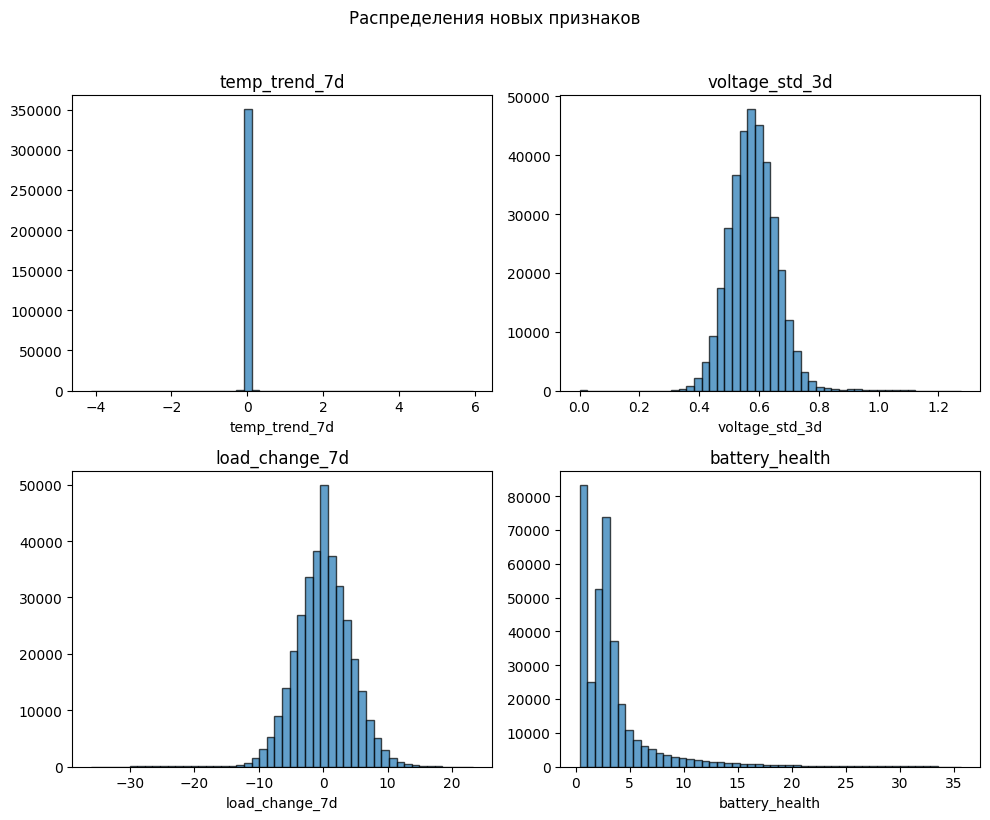

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(new_features):
    ax = axes.flatten()[i]
    ax.hist(df_fe[col].dropna(), bins=50, edgecolor="black", alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel(col)
plt.suptitle("Распределения новых признаков", y=1.02)
plt.tight_layout()
plt.show()
# Инсайт: temp_trend_7d и load_change_7d показывают динамику; battery_health и voltage_std_3d дополняют картину состояния.

## 6. Модель машинного обучения

Разделение по времени (первые 70% — train), обучение RandomForestClassifier, метрики и важность признаков.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Признаки: исходные числовые + новые
feature_cols = numeric_cols + new_features
X = df_fe[feature_cols]
y = df_fe["target"]

# Разделение по времени: первые 70% времени — train, последние 30% — test
df_fe_sorted = df_fe.sort_values("timestamp").reset_index(drop=True)
split_idx = int(0.7 * len(df_fe_sorted))
train_mask = df_fe_sorted.index < split_idx
X_train = df_fe_sorted.loc[train_mask, feature_cols]
X_test = df_fe_sorted.loc[~train_mask, feature_cols]
y_train = df_fe_sorted.loc[train_mask, "target"]
y_test = df_fe_sorted.loc[~train_mask, "target"]

print(f"Train: {X_train.shape[0]} образцов, Test: {X_test.shape[0]} образцов")
print(f"Доля target=1 в train: {y_train.mean():.4f}, в test: {y_test.mean():.4f}")

Train: 245615 образцов, Test: 105265 образцов
Доля target=1 в train: 0.0021, в test: 0.0032


In [39]:
model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# zero_division=0 убирает предупреждения, когда в test нет положительных или предсказанных положительных
print("Метрики на тестовой выборке:")
print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred, zero_division=0):.4f}")
if y_test.nunique() > 1:
    print(f"  ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
else:
    print("  ROC-AUC:   N/A (в тестовой выборке только один класс)")

Метрики на тестовой выборке:
  Precision: 0.9778
  Recall:    0.7857
  F1:        0.8713
  ROC-AUC:   0.9998


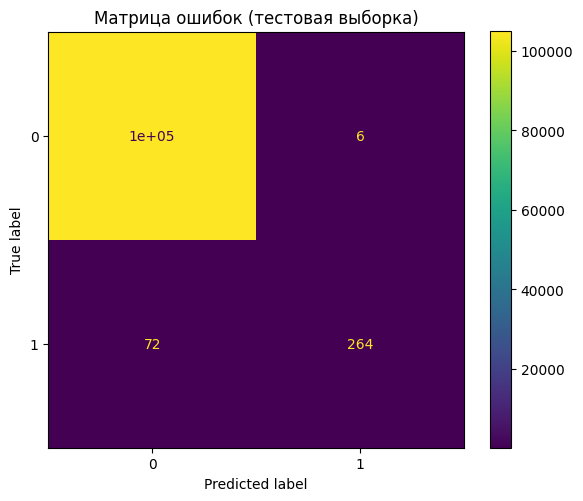

In [46]:
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], ax=ax, colorbar=True)
ax.set_title("Матрица ошибок (тестовая выборка)")
plt.tight_layout()
plt.show()

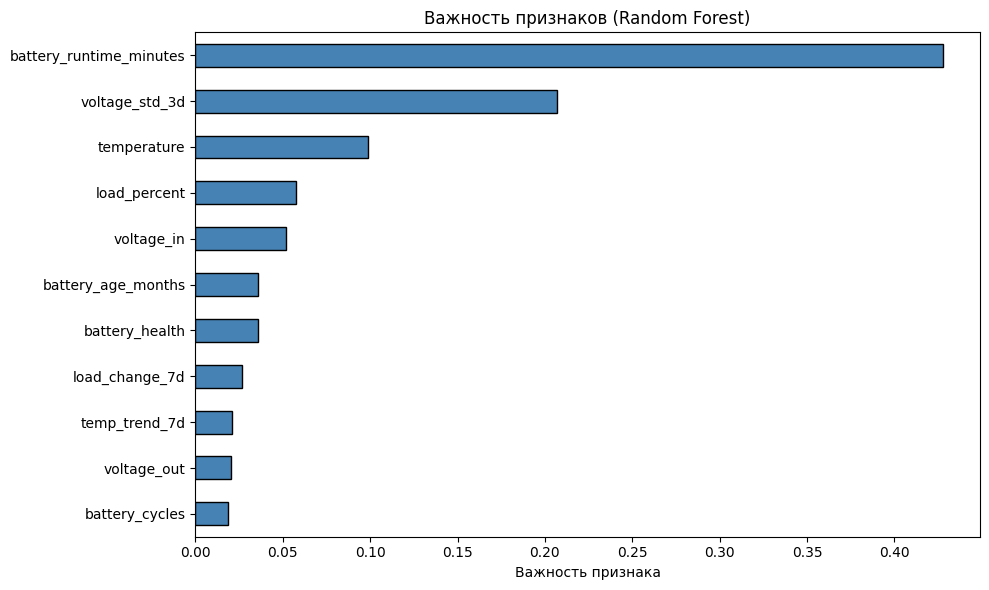

In [45]:
# Важность признаков — горизонтальный барчарт
imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=True)
imp.plot(kind="barh", figsize=(10, 6), color="steelblue", edgecolor="black")
plt.xlabel("Важность признака")
plt.title("Важность признаков (Random Forest)")
plt.tight_layout()
plt.show()

## 7. Выводы и рекомендации

**Бизнес-рекомендации по предиктивному обслуживанию ИБП:**

1. **Мониторинг температуры и нагрузки** — модель показывает, что температура и нагрузка сильнее всего связаны с риском отказа. Имеет смысл задать пороговые алерты (например, рост средней температуры за 7 дней или нагрузка > 80%) и планировать проверку/замену до наступления отказа.

2. **Окно предупреждения 2–4 недели** — по временным рядам видно, что за 2–4 недели до отказа параметры начинают деградировать. Рекомендуется использовать модель для еженедельного скоринга «риск отказа в ближайшие 7 дней» и заранее планировать ремонт или замену батареи.

3. **Признаки «здоровья» батареи** — battery_health (runtime/возраст), voltage_std_3d и тренды (temp_trend_7d, load_change_7d) улучшают предсказание. Стоит внедрить их в дашборды операторов и в автоматические отчёты.

4. **Разделение по времени при валидации** — при оценке модели мы разделили данные по времени (70% / 30%), что ближе к реальному сценарию «обучение на прошлом, предсказание в будущем». Такой подход стоит сохранить при A/B-тестах и при дообучении модели на новых данных.

5. **Баланс precision/recall** — в зависимости от стоимости ложных срабатываний vs. пропущенного отказа можно настроить порог классификатора (по умолчанию 0.5) или веса классов в Random Forest, чтобы сместить акцент на recall (меньше пропусков) или на precision (меньше ложных тревог).

In [48]:
import joblib
import json
import os
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Создаем папку models если её нет
os.makedirs('../models', exist_ok=True)

# Считаем метрики (если ещё не посчитаны)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("📊 Метрики модели:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1:        {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print()

# Сохраняем модель
model_filename = f'../models/ibp_model_{datetime.now().strftime("%Y%m%d")}.pkl'
joblib.dump(model, model_filename)
print(f"✅ Модель сохранена: {model_filename}")

# Сохраняем список признаков
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')
print(f"✅ Признаки сохранены: {len(feature_names)} шт.")

# Сохраняем метаданные
metadata = {
    'model_file': model_filename,
    'date': datetime.now().isoformat(),
    'features': feature_names,
    'n_features': len(feature_names),
    'metrics': {
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'roc_auc': float(roc_auc)
    },
    'feature_importance': dict(zip(feature_names, model.feature_importances_.tolist()))
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Метаданные сохранены: ../models/model_metadata.json")

# Сохраняем топ-5 важных признаков для README
top_features = sorted(zip(feature_names, model.feature_importances_), 
                     key=lambda x: x[1], reverse=True)[:5]
print("\n📊 Топ-5 важных признаков:")
for name, imp in top_features:
    print(f"  {name}: {imp:.3f}")

📊 Метрики модели:
  Precision: 0.9778
  Recall:    0.7857
  F1:        0.8713
  ROC-AUC:   0.9998

✅ Модель сохранена: ../models/ibp_model_20260220.pkl
✅ Признаки сохранены: 11 шт.
✅ Метаданные сохранены: ../models/model_metadata.json

📊 Топ-5 важных признаков:
  battery_runtime_minutes: 0.428
  voltage_std_3d: 0.207
  temperature: 0.099
  load_percent: 0.058
  voltage_in: 0.052
